# Gaussian process classifiers and CNN uncertainty

## To do:
- With and without learning phase

## Questions
- Is it possible to train the GP on all 60'000 training images?
    - Doesn't look like it... Either use more compute power or just use 1'000 or so examples

## Meeting notes (24/01/2018)
- Gaussian process should give more than just a probability, it should give an uncertainty for each probablity. Think $x$ where $P(C = k) = p \pm x$
- There is no conventional way of obtaining this with neural networks alone. One way that would be possible is to use dropout at classification time to obtain multiple samples, each a bit different, for the same probability and then look at the variance.
- Instead of looking at the difference in probabilities to decide whether we should classify and example or say "I don't know", use the lowerbound and upperbound of the two highest probabilities and see if they overlap

# Train CNN on MNIST

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np

from sklearn.metrics import classification_report
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt
%matplotlib inline

/Users/sebastian/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
model = keras.models.load_model('my_model.h5')

In [ ]:
#Load training data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

num_classes = 10
y_train_one_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

In [5]:
#Handle Theano and Tensorflow data format
img_rows, img_cols = 28,28

print("Image data format: {}".format(K.image_data_format()))

if K.image_data_format() == 'channel_first':
    X_train = x_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Image data format: channels_last


In [6]:
train_model = False
if train_model:
    batch_size = 128
    epochs = 12

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape)) 
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
    model.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test_one_hot))

In [7]:
#evaluate CNN
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Test loss: {}".format(score[0]))
print("Test accuracy: {}".format(score[1]))
print(X_test.shape)
cnn_predictions = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, cnn_predictions))

Test loss: 0.028256796755890535
Test accuracy: 0.9906
(10000, 28, 28, 1)
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       980
          1       0.99      1.00      0.99      1135
          2       0.99      0.99      0.99      1032
          3       0.99      1.00      0.99      1010
          4       0.99      0.99      0.99       982
          5       0.99      0.99      0.99       892
          6       0.99      0.99      0.99       958
          7       0.99      0.99      0.99      1028
          8       0.99      0.99      0.99       974
          9       0.99      0.99      0.99      1009

avg / total       0.99      0.99      0.99     10000



In [ ]:
def get_ith_layer_output(model, X, i, mode='test'):
    ''' see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'''
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode=='test' else 1])[0]
    return layer_output

In [8]:
last_layer_train_outputs = get_ith_layer_output(model, X_train, -2)

KeyboardInterrupt: 

In [ ]:
last_layer_test_outputs = get_ith_layer_output(model, X_test, -2)

#  Use a GP to predict output with uncertainty

- 10 inputs: 195 ms
- 100 inputs: 1.34 s
- 500 inputs: 42.3 s
- 1000 inputs: 3min 46s

$t = 1.125541126 \times 10^{-7} \times x^{3} + 1.143578644\times10^{-4} \times x^{2} - 1.106493506 \times 10^{-3} \times x + 1.945165945·10^{-1}$

Estimated for all 60'000 examples:
- 6867 hours ~ 286 days...

In [11]:
def estimate_time(inputs):
    return 1.125541126e-7 * (inputs**3) + 1.143578644e-4 * (inputs ** 2) - 1.106493506e-3 * inputs + 1.945165945e-1
estimate_time(60000) / 60 / 60 / 24

286.1494263697481

In [ ]:
kernel = 1.0 * RBF([1.0]) + WhiteKernel(noise_level=0.01)
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel, multi_class="one_vs_rest") 
# %time gpc_rbf_isotropic.fit(last_layer_train_outputs[:10],y_train[:10])
# %time gpc_rbf_isotropic.fit(last_layer_train_outputs[:100],y_train[:100])
# %time gpc_rbf_isotropic.fit(last_layer_train_outputs[:500],y_train[:500])
%time gpc_rbf_isotropic = gpc_rbf_isotropic.fit(last_layer_train_outputs[:100],y_train[:100])
# %time gpc_rbf_isotropic.fit(last_layer_train_outputs[:10000],y_train[:10000])
# %time gpc_rbf_isotropic.fit(last_layer_train_outputs, y_train)

In [13]:
print("Trained model: {}".format(str(gpc_rbf_isotropic.kernel_)))
print("Log-marginal likelihood: {}".format(gpc_rbf_isotropic.log_marginal_likelihood()))

Trained model: CompoundKernel(7.39, 3.79, -11.5, 7.51, 3.69, -11.5, 7.57, 3.85, -11.5, 7.59, 3.87, -11.5, 7.81, 3.78, -11.5, 7.57, 3.75, -11.5, 7.65, 3.83, -11.5, 7.64, 3.75, -11.5, 7.85, 3.92, -11.5, 7.83, 3.89, -11.5)
Log-marginal likelihood: -27.590566136693383


In [14]:
predictions_proba = gpc_rbf_isotropic.predict_proba(last_layer_test_outputs)
predictions = np.argmax(predictions_proba, axis=1)

In [16]:
print(classification_report(predictions, y_test))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       984
          1       1.00      0.99      1.00      1138
          2       0.99      0.99      0.99      1039
          3       0.98      1.00      0.99       995
          4       0.98      0.99      0.99       971
          5       1.00      0.98      0.99       909
          6       0.99      0.99      0.99       958
          7       0.99      0.98      0.99      1030
          8       0.98      0.99      0.99       961
          9       0.98      0.98      0.98      1015

avg / total       0.99      0.99      0.99     10000



In [17]:
correct_indices = np.argwhere(predictions == y_test)
incorrect_indices = np.argwhere(predictions != y_test)
accuracy = len(correct_indices) / len(y_test)
print("Incorreclty labelled examples: {}".format(len(incorrect_indices)))
print("Accuracy: {}".format(accuracy))

Incorreclty labelled examples: 111
Accuracy: 0.9889


In [ ]:
correct_probabilities = predictions_proba[correct_indices].reshape(-1, 10)
correct_probabilities_correct_label = np.max(correct_probabilities, axis=1)
plt.title("Probability assigned to the correct label in correclty labelled examples")
plt.hist(correct_probabilitis, bins=50);

In [19]:
#indices of highest 2 probabilites
max2_indices = np.argpartition(correct_probabilities, -2, axis=1)[:,-2:]
#retrieve probabilites
max1_correct_probabilities = correct_probabilities[np.arange(len(correct_probabilities)), max2_indices[:,0]]
max2_correct_probabilities = correct_probabilities[np.arange(len(correct_probabilities)), max2_indices[:,1]]

max2_difference_correct_probabilities = np.abs(max1_correct_probabilities - max2_probabilities_correct_label)
plt.title("Difference between highest and second highest probability in correclty labelled examples")
plt.hist(max2_difference_correct_probabilities, bins=50);

NameError: name 'max2_probabilities_correct_label' is not defined

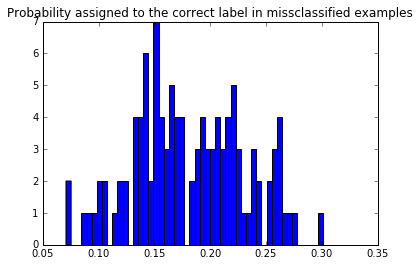

In [20]:
#compute probability assigned to the correct label in missclassified examples
incorrect_probabilities = predictions_proba[incorrect_indices].reshape(-1, 10)
correct_predictions = y_test[incorrect_indices].reshape(-1)
incorrect_probabilities_correct_label = incorrect_probabilities[np.arange(len(correct_predictions)), correct_predictions]
plt.title("Probability assigned to the correct label in missclassified examples")
plt.hist(incorrect_probabilities_correct_label, bins=50);

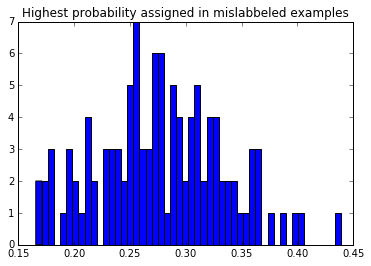

In [21]:
#highest probability assigned in mislabbeled examples
incorrect_probabilities_max = np.max(incorrect_probabilities, axis=1)
plt.title("Highest probability assigned in mislabbeled examples")
plt.hist(incorrect_probabilities_max, bins=50);

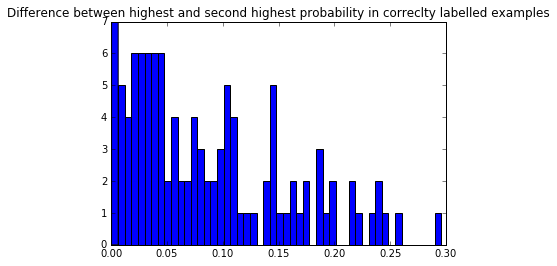

In [22]:
#indices of highest 2 probabilites
max2_indices_incorrect = np.argpartition(incorrect_probabilities, -2, axis=1)[:,-2:]
#retrieve probabilites
max1_incorrect_probabilities = incorrect_probabilities[np.arange(len(incorrect_probabilities)), max2_indices_incorrect[:,0]]
max2_incorrect_probabilities = incorrect_probabilities[np.arange(len(incorrect_probabilities)), max2_indices_incorrect[:,1]]

max2_difference_incorrect_probabilities = np.abs(max1_incorrect_probabilities - max2_incorrect_probabilities)
plt.title("Difference between highest and second highest probability in correclty labelled examples")
plt.hist(max2_difference_incorrect_probabilities, bins=50);

In [23]:
cut_off = 0.1

def compute_cut_off_values(cut_off):
    false_negatives = len(np.argwhere(max2_difference_correct_probabilities < cut_off))
    false_positives = len(np.argwhere(max2_difference_incorrect_probabilities > cut_off))
    false_negatives_rate = false_negatives/len(correct_indices)
    false_positives_rate = false_positives/len(incorrect_indices)
    return (false_negatives_rate, false_positives_rate)

false_negatives, true_negatives = compute_cut_off_values(cut_off)
print("Number of correclty assigned examples that wouldn't be assigned a class:")
print("{}".format((false_negatives * len(correct_indices))))

print("Number of incorreclty assigned examples that would be assigned a class:")
print("{}".format(true_negatives * len(incorrect_indices)))

cut_offs = np.linspace(0.0, 0.35, num = 100)
y = np.vectorize(compute_cut_off_values)(cut_offs)
plt.plot(cut_offs, y[0], label="false negatives rate")
plt.plot(cut_offs, y[1], label="false positives rate")
plt.legend()

NameError: name 'max2_difference_correct_probabilities' is not defined

In [24]:
cut_offs = np.linspace

# Inspect examples classified differently

In [25]:
len(np.argwhere(cnn_predictions != predictions))

81

In [26]:
#Number of elements classified correclty by CNN and not by GP
len(np.argwhere((cnn_predictions == y_test) & (predictions != y_test)))

48

In [27]:
#Number of elements classified correclty by GP and not by CNN
len(np.argwhere((cnn_predictions != y_test) & (predictions == y_test)))

31

In [28]:
#Number of elements missclassified by both
len(np.argwhere((cnn_predictions != y_test) & (predictions != y_test)))

63

CNN prediction: 3
GP prediction: 5
GP confidence: 0.274 from [0.045 0.083 0.05  0.171 0.051 0.274 0.056 0.053 0.138 0.079]


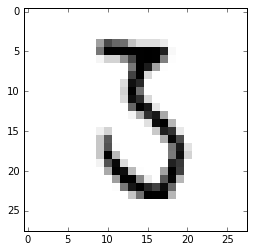

In [29]:
index = np.argwhere((cnn_predictions == y_test) & (predictions != y_test))[9][0]
plt.imshow(X_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 
print("CNN prediction: {}".format(cnn_predictions[index]))
print("GP prediction: {}".format(predictions[index]))
print("GP confidence: {} from {}".format(np.round(np.max(predictions_proba[index]),3), np.round(predictions_proba[index], decimals=3)))

CNN prediction: 3
GP prediction: 1
GP confidence: 0.166 from [0.044 0.166 0.106 0.125 0.067 0.066 0.088 0.144 0.11  0.084]
Correct label: 7


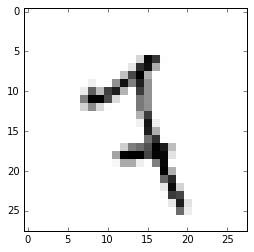

In [30]:
index = np.argwhere((cnn_predictions != y_test) & (predictions != y_test) & (predictions != cnn_predictions))[0][0]
plt.imshow(X_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 
print("CNN prediction: {}".format(cnn_predictions[index]))
print("GP prediction: {}".format(predictions[index]))
print("GP confidence: {} from {}".format(np.round(np.max(predictions_proba[index]),3), np.round(predictions_proba[index], decimals=3)))
print("Correct label: {}".format(y_test[index]))

CNN prediction: 7
GP prediction: 7
GP confidence: 0.319 from [0.055 0.055 0.212 0.097 0.035 0.037 0.059 0.319 0.094 0.037]
Correct label: 2


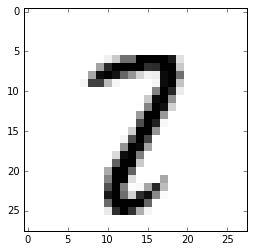

In [31]:
index = np.argwhere((cnn_predictions != y_test) & (predictions != y_test) & (predictions == cnn_predictions))[0][0]
plt.imshow(X_test[index].reshape(28,28),cmap =plt.cm.gray_r, interpolation = "nearest") 
print("CNN prediction: {}".format(cnn_predictions[index]))
print("GP prediction: {}".format(predictions[index]))
print("GP confidence: {} from {}".format(np.round(np.max(predictions_proba[index]),3), np.round(predictions_proba[index], decimals=3)))
print("Correct label: {}".format(y_test[index]))